In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
users = pd.read_csv('takehome_users.csv', parse_dates=['creation_time'], encoding='latin1')
engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'], encoding='latin1')

In [5]:
def label_adopted(df_eng, user_col='user_id', ts_col='time_stamp'):
    df_eng['date'] = df_eng[ts_col].dt.date
    grouped = df_eng.groupby(user_col)['date'].unique().reset_index()
    
    def user_adopted(dates):
        if len(dates) < 3:
            return 0
        dates = sorted(pd.to_datetime(dates))
        i = 0
        for j in range(len(dates)):
            while (dates[j] - dates[i]).days > 6:
                i += 1
            if j - i + 1 >= 3:
                return 1
        return 0

    grouped['adopted'] = grouped['date'].apply(user_adopted)
    return grouped[[user_col, 'adopted']]

In [6]:
user_id_col_eng = 'user_id' if 'user_id' in engagement.columns else 'object_id'
adopted_df = label_adopted(engagement, user_col=user_id_col_eng)

In [7]:
user_id_col_users = 'object_id'
users_labels = users.merge(adopted_df, left_on=user_id_col_users, right_on=user_id_col_eng, how='left')
users_labels['adopted'] = users_labels['adopted'].fillna(0).astype(int)

In [8]:
df = users_labels.copy()

In [9]:
df['invited'] = (~df['invited_by_user_id'].isnull()).astype(int)

In [10]:
for col in ['opted_in_to_mailing_list','enabled_for_marketing_drip']:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype(int)

In [11]:
if 'last_session_creation_time' in df.columns:
    try:
        df['last_session_dt'] = pd.to_datetime(df['last_session_creation_time'], unit='s')
    except:
        df['last_session_dt'] = pd.to_datetime(df['last_session_creation_time'], errors='coerce')
    df['days_since_last_session'] = (pd.Timestamp.now() - df['last_session_dt']).dt.days
else:
    df['days_since_last_session'] = np.nan

In [12]:
feature_cols = ['invited','opted_in_to_mailing_list','enabled_for_marketing_drip','days_since_last_session','creation_source']
X = df[feature_cols]
y = df['adopted']

In [13]:
X = pd.get_dummies(X, columns=['creation_source'], drop_first=True)
X['days_since_last_session'] = X['days_since_last_session'].fillna(X['days_since_last_session'].median())

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [16]:
y_pred_proba = rf.predict_proba(X_test)[:,1]

In [17]:
roc = roc_auc_score(y_test, y_pred_proba)
print("Random Forest ROC AUC:", round(roc,3))

Random Forest ROC AUC: 0.86


In [18]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop 10 feature importances:\n", importances.head(10))


Top 10 feature importances:
 days_since_last_session               0.969064
creation_source_PERSONAL_PROJECTS     0.009172
enabled_for_marketing_drip            0.005514
opted_in_to_mailing_list              0.005058
creation_source_ORG_INVITE            0.004147
invited                               0.002658
creation_source_SIGNUP                0.002209
creation_source_SIGNUP_GOOGLE_AUTH    0.002178
dtype: float64


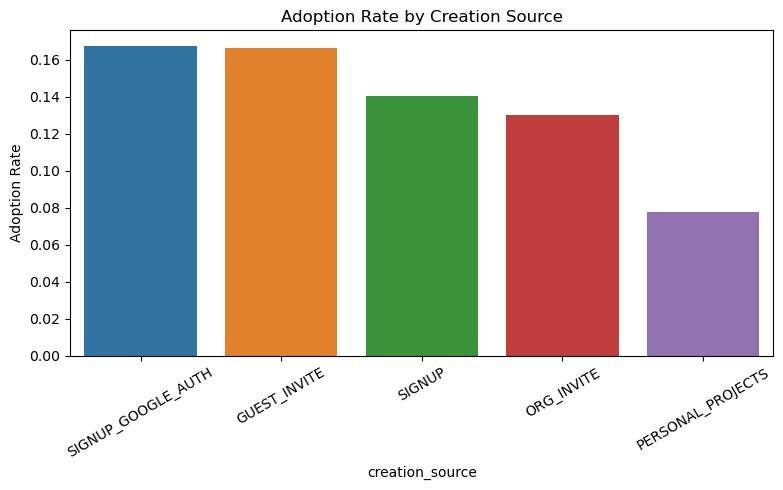

In [19]:
plt.figure(figsize=(8,5))
adoption_rate = df.groupby('creation_source')['adopted'].mean().sort_values(ascending=False)
sns.barplot(x=adoption_rate.index, y=adoption_rate.values)
plt.ylabel("Adoption Rate")
plt.title("Adoption Rate by Creation Source")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()